This is the working copy of the VTK smoother function.  It only works with the VTK viewer.  The next step is to output the file and also view it inside the Jupyter interface.

# Imports

In [1]:
# An example from scipy cookbook demonstrating the use of numpy arrys in vtk  
import vtk
import numpy as np
from IPython.display import Image

# Functions

In [2]:
def numpyToVTK(data_matrix):
    # For VTK to be able to use the data, it must be stored as a VTK-image. This can be done by the vtkImageImport-class which
    # imports raw data and stores it.
    dataImporter = vtk.vtkImageImport()
    # The preaviusly created array is converted to a string of chars and imported.
    data_string = data_matrix.tostring()
    dataImporter.CopyImportVoidPointer(data_string, len(data_string))
    # The type of the newly imported data is set to unsigned char (uint8)
    dataImporter.SetDataScalarTypeToUnsignedChar()
    # Because the data that is imported only contains an intensity value (it isnt RGB-coded or someting similar), the importer
    # must be told this is the case.
    dataImporter.SetNumberOfScalarComponents(1)
    
    # The following two functions describe how the data is stored and the dimensions of the array it is stored in. 
    extent = dataImporter.GetDataExtent()
    dim = stack.shape
    dataImporter.SetDataExtent(extent[0], extent[0] + dim[2] - 1,
                               extent[2], extent[2] + dim[1] - 1,
                               extent[4], extent[4] + dim[0] - 1)
    dataImporter.SetWholeExtent(extent[0], extent[0] + dim[2] - 1,
                                extent[2], extent[2] + dim[1] - 1,
                                extent[4], extent[4] + dim[0] - 1)
    
    return dataImporter    

In [3]:
def vtk_show(renderer, width=400, height=400):
    """
    Takes vtkRenderer instance and returns an IPython Image with the rendering.
    """
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(width, height)
    renderWindow.Render()
     
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()
     
    writer = vtk.vtkPNGWriter()
    writer.SetWriteToMemory(1)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    data = str(buffer(writer.GetResult()))
    
    return Image(data)

# Main

## Reading the Data

In [4]:
dbDir = 'C:/Cerebral/_MarioSandBox/DB/medicalHolography/pythonVariables/'
filteredImageFileName = dbDir + 'thStackMorphologyApplied.npy'

In [5]:
stack = np.load(filteredImageFileName)

In [6]:
np.shape(stack)

(180L, 760L, 766L)

In [7]:
stack.dtype

dtype('uint8')

In [8]:
data_matrix = stack

In [9]:
np.amax(data_matrix[0])

255

In [10]:
np.amin(data_matrix[0])

0

## VTK Stuff 

In [11]:
dataImporter = numpyToVTK(stack)

In [12]:
# The following class is used to store transparencyv-values for later retrival. In our case, we want the value 0 to be
# completly opaque whereas the three different cubes are given different transperancy-values to show how it works.
alphaChannelFunc = vtk.vtkPiecewiseFunction()
alphaChannelFunc.AddPoint(0, 0.0)
#alphaChannelFunc.AddPoint(50, 0.05)
#alphaChannelFunc.AddPoint(100, 0.1)
#alphaChannelFunc.AddPoint(150, 0.2)
alphaChannelFunc.AddPoint(255, 0.2)
 
# This class stores color data and can create color tables from a few color points. For this demo, we want the three cubes
# to be of the colors red green and blue.
colorFunc = vtk.vtkColorTransferFunction()
colorFunc.AddRGBPoint(0, 1.0, 0.0, 0.0)
#colorFunc.AddRGBPoint(50, 1.0, 0.0, 0.0)
#colorFunc.AddRGBPoint(100, 0.0, 1.0, 0.0)
#colorFunc.AddRGBPoint(150, 0.0, 0.0, 1.0)
colorFunc.AddRGBPoint(255, 0.0, 0.0, 1.0)

# The preavius two classes stored properties. Because we want to apply these properties to the volume we want to render,
# we have to store them in a class that stores volume prpoperties.
volumeProperty = vtk.vtkVolumeProperty()
volumeProperty.SetColor(colorFunc)
volumeProperty.SetScalarOpacity(alphaChannelFunc)

In [13]:
# This class describes how the volume is rendered (through ray tracing).
compositeFunction = vtk.vtkVolumeRayCastCompositeFunction()
# We can finally create our volume. We also have to specify the data for it, as well as how the data will be rendered.
volumeMapper = vtk.vtkVolumeRayCastMapper()
volumeMapper.SetVolumeRayCastFunction(compositeFunction)
volumeMapper.SetInputConnection(dataImporter.GetOutputPort())
 
# The class vtkVolume is used to pair the preaviusly declared volume as well as the properties to be used when rendering that volume.
volume = vtk.vtkVolume()
volume.SetMapper(volumeMapper)
volume.SetProperty(volumeProperty)

In [14]:
# With almost everything else ready, its time to initialize the renderer and window, as well as creating a method for exiting the application
renderer = vtk.vtkRenderer()
renderWin = vtk.vtkRenderWindow()
renderWin.AddRenderer(renderer)
renderInteractor = vtk.vtkRenderWindowInteractor()
renderInteractor.SetRenderWindow(renderWin)
 
# We add the volume to the renderer ...
renderer.AddVolume(volume)
# ... set background color to white ...
renderer.SetBackground(0,0,0)
# ... and set window size.
renderWin.SetSize(400, 400)

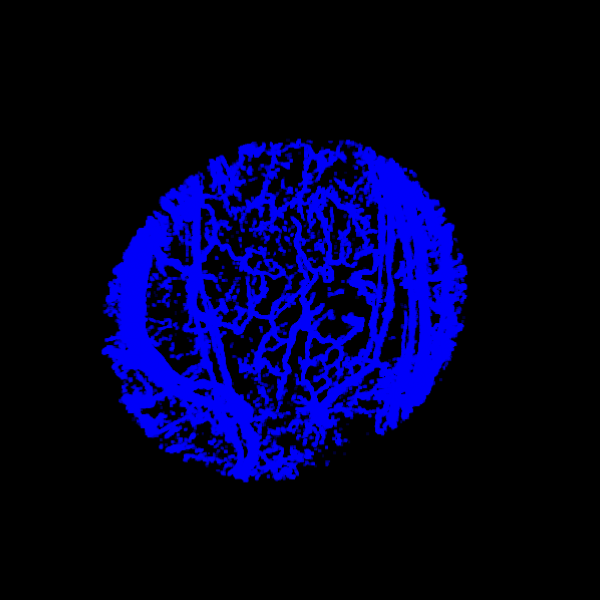

In [15]:
vtk_show(renderer, 600, 600)

# Application of Marching Cube Algorithm

In [16]:
dmc = vtk.vtkDiscreteMarchingCubes()
dmc.SetInputConnection(dataImporter.GetOutputPort())
dmc.Update()

# Application of Smoothing Algorithm

I think there are two methods for smoothing the data
- [Interpolatin](http://itk-insight-users.2283740.n2.nabble.com/How-to-smooth-the-segmented-surface-td7387850.html).  Basically because we don't have enough samples between the slices it looks very choppy.  I think this is inherent in all scanning type biomedical imaging.
- Plying a VTK function called vtkWindowedSincPolyDataFilter on it.  I guess for this we can use these examples to try and see which ones works best [ex1](https://www.vtk.org/Wiki/VTK/Examples/Python/MeshLabelImageColor) [ex2](https://discourse.slicer.org/t/apply-laplacian-smoothing-using-python-script/2438) [ex3](https://github.com/Kitware/vtk-js/issues/540) [ex4](https://lorensen.github.io/VTKExamples/site/Python/PolyData/SmoothMeshGrid/)

## VTK Approach

In [17]:
smoother= vtk.vtkWindowedSincPolyDataFilter()
smoother.SetInputConnection(dmc.GetOutputPort())

In [18]:
smoother.SetNumberOfIterations(30) #this has little effect on the error!
#smoother.BoundarySmoothingOff()
#smoother.FeatureEdgeSmoothingOff()
#smoother.SetFeatureAngle(120.0)
#smoother.SetPassBand(.001)        #this increases the error a lot!
smoother.NonManifoldSmoothingOn()
smoother.NormalizeCoordinatesOn()
smoother.GenerateErrorScalarsOn()
#smoother.GenerateErrorVectorsOn()
smoother.Update()

In [19]:
smoothed_polys= smoother.GetOutput()
smoother_error= smoothed_polys.GetPointData().GetScalars()
 
##Find min and max z
se_range= smoother_error.GetRange()
print(se_range)
minz= se_range[0] #min(smoother_error)
maxz= se_range[1] #max(smoother_error)
if (maxz > 1):
    print("Big smoother error: min/max:", minz, maxz)
minz=  .3 #this way colours of different particles are comparable
maxz= 1

(0.0, 1.8709121942520142)
('Big smoother error: min/max:', 0.0, 1.8709121942520142)


In [20]:
## Create the color map
colorLookupTable= vtk.vtkLookupTable()
colorLookupTable.SetTableRange(minz, maxz) #this does nothing, use mapper.SetScalarRange(minz, maxz)
colorLookupTable.SetHueRange(2/3.0, 1)
#colorLookupTable.SetSaturationRange(0, 0)
#colorLookupTable.SetValueRange(1, 0)
#colorLookupTable.SetNumberOfColors(256) #256 default
colorLookupTable.Build()

In [21]:
##calc cell normal
triangleCellNormals= vtk.vtkPolyDataNormals()
if vtk.VTK_MAJOR_VERSION <= 5:
    triangleCellNormals.SetInput(smoothed_polys)
else:
    triangleCellNormals.SetInputData(smoothed_polys)
triangleCellNormals.ComputeCellNormalsOn()
triangleCellNormals.ComputePointNormalsOff()
triangleCellNormals.ConsistencyOn()
triangleCellNormals.AutoOrientNormalsOn()
triangleCellNormals.Update() #creates vtkPolyData 

In [22]:
mapper= vtk.vtkPolyDataMapper()
#mapper.SetInput(smoothed_polys) #this has no normals
if vtk.VTK_MAJOR_VERSION <= 5:
    mapper.SetInput(triangleCellNormals.GetOutput()) #this is better for vis;-)
else:
    mapper.SetInputConnection(triangleCellNormals.GetOutputPort()) #this is better for vis;-)
mapper.ScalarVisibilityOn()#show colour
mapper.SetScalarRange(minz, maxz)
#mapper.SetScalarModeToUseCellData() # contains the label eg. 31
mapper.SetScalarModeToUsePointData() #the smoother error relates to the verts
mapper.SetLookupTable(colorLookupTable)

In [23]:
# Take the isosurface data and create geometry
 
actor = vtk.vtkLODActor()
 
actor.SetNumberOfCloudPoints( 100000 )
actor.SetMapper(mapper)

In [24]:
# Create renderer
 
ren = vtk.vtkRenderer()
ren.SetBackground( 0, 0, 0 )
ren.AddActor(actor)
 
 
 
# Create a window for the renderer of size 250x250
 
renWin = vtk.vtkRenderWindow()
 
renWin.AddRenderer(ren)
renWin.SetSize(250, 250)
 
 
 
# Set an user interface interactor for the render window
 
iren = vtk.vtkRenderWindowInteractor()
 
iren.SetRenderWindow(renWin)
 
 
 
# Start the initialization and rendering
 
iren.Initialize()
renWin.Render()
iren.Start()